In [1]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torchaudio.transforms as T
import torchvision, torchaudio
import torch.optim as optim
import scipy as sp
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import datetime
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [2]:
%cd ..

/home/gatanasio/SSPT_IMU


/home/gatanasio/miniconda3/envs/audio-mae/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
root_dir = os.path.join('/data2', 'WEAR')
'''
Annotations:
    - wear_split_1.json
    - wear_split_2.json
    - wear_split_3.json
'''
annotations_dir = os.path.join(root_dir, 'annotations')
inertial_dir = os.path.join(root_dir, 'raw', 'inertial')
annotations_file = 'wear_split_1.json'

train = True

In [4]:
df_ann1 = pd.read_json(os.path.join(annotations_dir, annotations_file))
df_ann2 = pd.read_json(os.path.join(annotations_dir, 'wear_split_2.json'))
df_ann3 = pd.read_json(os.path.join(annotations_dir, 'wear_split_3.json'))


In [4]:
len(df_ann1), len(df_ann2), len(df_ann3)

(36, 36, 36)

In [5]:
df_ann1

,version,database,label_dict
sbj_6,Wear,"{'subset': 'Training', 'duration': 2503.5, 'fp...",NaN
sbj_7,Wear,"{'subset': 'Training', 'duration': 2853.0, 'fp...",NaN
sbj_8,Wear,"{'subset': 'Training', 'duration': 2495.0, 'fp...",NaN
sbj_9,Wear,"{'subset': 'Training', 'duration': 2166.0, 'fp...",NaN
sbj_10,Wear,"{'subset': 'Training', 'duration': 3985.0, 'fp...",NaN
sbj_11,Wear,"{'subset': 'Training', 'duration': 2222.0, 'fp...",NaN
sbj_12,Wear,"{'subset': 'Training', 'duration': 3270.0, 'fp...",NaN
sbj_13,Wear,"{'subset': 'Training', 'duration': 3978.0, 'fp...",NaN
sbj_14,Wear,"{'subset': 'Training', 'duration': 3201.0, 'fp...",NaN
sbj_15,Wear,"{'subset': 'Training', 'duration': 2603.0, 'fp...",NaN


In [6]:
df_ann2

,version,database,label_dict
sbj_0,Wear,"{'subset': 'Training', 'duration': 2794.5, 'fp...",NaN
sbj_1,Wear,"{'subset': 'Training', 'duration': 2778.0, 'fp...",NaN
sbj_2,Wear,"{'subset': 'Training', 'duration': 3564.0, 'fp...",NaN
sbj_3,Wear,"{'subset': 'Training', 'duration': 4171.0, 'fp...",NaN
sbj_4,Wear,"{'subset': 'Training', 'duration': 3191.5, 'fp...",NaN
sbj_5,Wear,"{'subset': 'Training', 'duration': 2150.5, 'fp...",NaN
sbj_12,Wear,"{'subset': 'Training', 'duration': 3270.0, 'fp...",NaN
sbj_13,Wear,"{'subset': 'Training', 'duration': 3978.0, 'fp...",NaN
sbj_14,Wear,"{'subset': 'Training', 'duration': 3201.0, 'fp...",NaN
sbj_15,Wear,"{'subset': 'Training', 'duration': 2603.0, 'fp...",NaN


In [7]:
df_ann3

,version,database,label_dict
sbj_0,Wear,"{'subset': 'Training', 'duration': 2794.5, 'fp...",NaN
sbj_1,Wear,"{'subset': 'Training', 'duration': 2778.0, 'fp...",NaN
sbj_2,Wear,"{'subset': 'Training', 'duration': 3564.0, 'fp...",NaN
sbj_3,Wear,"{'subset': 'Training', 'duration': 4171.0, 'fp...",NaN
sbj_4,Wear,"{'subset': 'Training', 'duration': 3191.5, 'fp...",NaN
sbj_5,Wear,"{'subset': 'Training', 'duration': 2150.5, 'fp...",NaN
sbj_6,Wear,"{'subset': 'Training', 'duration': 2503.5, 'fp...",NaN
sbj_7,Wear,"{'subset': 'Training', 'duration': 2853.0, 'fp...",NaN
sbj_8,Wear,"{'subset': 'Training', 'duration': 2495.0, 'fp...",NaN
sbj_9,Wear,"{'subset': 'Training', 'duration': 2166.0, 'fp...",NaN


In [11]:
labels = df_ann1[df_ann1['label_dict'].notna()]
labels = labels.drop(columns=['version', 'database'])
labels

,label_dict
jogging,0.0
jogging (rotating arms),1.0
jogging (skipping),2.0
jogging (sidesteps),3.0
jogging (butt-kicks),4.0
stretching (triceps),5.0
stretching (lunging),6.0
stretching (shoulders),7.0
stretching (hamstrings),8.0
stretching (lumbar rotation),9.0


In [ ]:
df_clean_split = pd.DataFrame(columns=['file', 'label', 'split'])

In [13]:
src_dir = os.path.join('data', 'WEAR', 'annotations')
cls_file = 'wear_cls.pkl'
os.makedirs(src_dir, exist_ok=True)
pd.to_pickle(labels, os.path.join(src_dir, cls_file))

In [14]:
df = df_ann1['database'].iloc[0]
df = pd.DataFrame(df)

In [15]:
df

,subset,duration,fps,annotations
0,Training,2503.5,60.0,"{'label': 'jogging', 'segment': [1.4, 135.42],..."
1,Training,2503.5,60.0,"{'label': 'push-ups', 'segment': [184.2, 192.9..."
2,Training,2503.5,60.0,"{'label': 'push-ups', 'segment': [198.34, 208...."
3,Training,2503.5,60.0,"{'label': 'push-ups', 'segment': [216.06, 224...."
4,Training,2503.5,60.0,"{'label': 'push-ups', 'segment': [229.18, 293...."
5,Training,2503.5,60.0,"{'label': 'jogging (sidesteps)', 'segment': [3..."
6,Training,2503.5,60.0,"{'label': 'lunges', 'segment': [447.94, 557.42..."
7,Training,2503.5,60.0,"{'label': 'stretching (hamstrings)', 'segment'..."
8,Training,2503.5,60.0,"{'label': 'stretching (hamstrings)', 'segment'..."
9,Training,2503.5,60.0,"{'label': 'sit-ups', 'segment': [795.18, 871.8..."


In [16]:
df.query('subset == "Training"')

,subset,duration,fps,annotations
0,Training,2503.5,60.0,"{'label': 'jogging', 'segment': [1.4, 135.42],..."
1,Training,2503.5,60.0,"{'label': 'push-ups', 'segment': [184.2, 192.9..."
2,Training,2503.5,60.0,"{'label': 'push-ups', 'segment': [198.34, 208...."
3,Training,2503.5,60.0,"{'label': 'push-ups', 'segment': [216.06, 224...."
4,Training,2503.5,60.0,"{'label': 'push-ups', 'segment': [229.18, 293...."
5,Training,2503.5,60.0,"{'label': 'jogging (sidesteps)', 'segment': [3..."
6,Training,2503.5,60.0,"{'label': 'lunges', 'segment': [447.94, 557.42..."
7,Training,2503.5,60.0,"{'label': 'stretching (hamstrings)', 'segment'..."
8,Training,2503.5,60.0,"{'label': 'stretching (hamstrings)', 'segment'..."
9,Training,2503.5,60.0,"{'label': 'sit-ups', 'segment': [795.18, 871.8..."


In [80]:
df.loc[0, 'annotations']

{'label': 'jogging',
 'segment': [1.4, 135.42],
 'segment (frames)': [84.0, 8125.199999999999],
 'label_id': 0}

# Splits creation

In [81]:
df_refactored = pd.DataFrame(columns=['sbj_id', 'subset', 'label_id', 'start_s', 'stop_s', 'start_frame', 'stop_frame'])

In [85]:
df_start = df_ann1[df_ann1['label_dict'].isna()].drop(columns=['version', 'label_dict'])
df_start['sbj_id'] = df_start.index
df_start.reset_index(drop=True, inplace=True)
df_start

,database,sbj_id
0,"{'subset': 'Training', 'duration': 2503.5, 'fp...",sbj_6
1,"{'subset': 'Training', 'duration': 2853.0, 'fp...",sbj_7
2,"{'subset': 'Training', 'duration': 2495.0, 'fp...",sbj_8
3,"{'subset': 'Training', 'duration': 2166.0, 'fp...",sbj_9
4,"{'subset': 'Training', 'duration': 3985.0, 'fp...",sbj_10
5,"{'subset': 'Training', 'duration': 2222.0, 'fp...",sbj_11
6,"{'subset': 'Training', 'duration': 3270.0, 'fp...",sbj_12
7,"{'subset': 'Training', 'duration': 3978.0, 'fp...",sbj_13
8,"{'subset': 'Training', 'duration': 3201.0, 'fp...",sbj_14
9,"{'subset': 'Training', 'duration': 2603.0, 'fp...",sbj_15


In [105]:
def extract_annotations(df):
    df_refactored = pd.DataFrame(columns=['sbj_id', 'subset', 'label_id', 'start_s', 'stop_s', 'start_frame', 'stop_frame'])
    
    for idx, row in df.iterrows():
        sbj_id = row['sbj_id']
        database = pd.DataFrame(row['database'])
        new_cols = {
            'start_s': database['annotations'].apply(lambda x: x['segment'][0]),
            'stop_s': database['annotations'].apply(lambda x: x['segment'][1]),
            'start_frame': database['annotations'].apply(lambda x: x['segment (frames)'][0]),
            'stop_frame': database['annotations'].apply(lambda x: x['segment (frames)'][1]),
            'label_id': database['annotations'].apply(lambda x: x['label_id'])
        }
        database = database.assign(**new_cols)
        database['sbj_id'] = sbj_id
        database = database.drop(columns=['annotations', 'fps'])
        df_refactored = pd.concat([df_refactored, database])

    df_refactored.reset_index(drop=True, inplace=True)
    return df_refactored

In [107]:
df_new = extract_annotations(df_start)

/tmp/ipykernel_435373/752143232.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_refactored = pd.concat([df_refactored, database])


In [114]:
len(df_new['label_id'][df_new['subset']=='Validation'].unique()), len(df_new)

(18, 597)

In [180]:
filename_refactored = 'wear_annotations_refactored.pkl'
pd.to_pickle(df_new, os.path.join(src_dir, filename_refactored))

In [181]:
# create training split
df_tmp = df_new
df_tmp['sbj_id'][df_tmp['subset']=='Validation'].unique()

array(['sbj_0', 'sbj_1', 'sbj_2', 'sbj_3', 'sbj_4', 'sbj_5'], dtype=object)

In [182]:
for sbj_id in ['sbj_0', 'sbj_1', 'sbj_2']:
    df_tmp.loc[df_tmp['sbj_id']==sbj_id, 'subset'] = 'Training'

In [184]:
df_train = df_tmp[df_tmp['subset']=='Training'].drop(columns=['subset'])
df_val = df_tmp[df_tmp['subset']=='Validation'].drop(columns=['subset'])

In [185]:
pd.to_pickle(df_train, os.path.join(src_dir, 'wear_annotations_refactored_train.pkl'))
pd.to_pickle(df_val, os.path.join(src_dir, 'wear_annotations_refactored_val.pkl'))

In [186]:
f'# Training: {len(df_train)}, #Validation: {len(df_val)}'

'# Training: 465, #Validation: 132'

In [193]:
df_train

,sbj_id,label_id,start_s,stop_s,start_frame,stop_frame,duration
0,sbj_6,0,1.40,135.42,84.0,8125.2,2503.5
1,sbj_6,10,184.20,192.98,11052.0,11578.8,2503.5
2,sbj_6,10,198.34,208.34,11900.4,12500.4,2503.5
3,sbj_6,10,216.06,224.90,12963.6,13494.0,2503.5
4,sbj_6,10,229.18,293.80,13750.8,17628.0,2503.5
...,...,...,...,...,...,...,...
460,sbj_2,16,3227.12,3267.92,193627.2,196075.2,3564.0
461,sbj_2,17,3286.86,3317.70,197211.6,199062.0,3564.0
462,sbj_2,17,3349.54,3378.84,200972.4,202730.4,3564.0
463,sbj_2,17,3415.52,3445.18,204931.2,206710.8,3564.0


In [195]:
sbj_duration = df_train[['sbj_id', 'duration']]

In [199]:
len(df_train[['sbj_id', 'duration']].drop_duplicates())

15

In [192]:
df_train['sbj_id', 'duration'].unique()

KeyError: ('sbj_id', 'duration')

# Data Visualization

In [5]:

annotations_dir = os.path.join('data', 'WEAR', 'annotations')
annotations_file = 'wear_annotations_refactored.pkl'
df_ann = pd.read_pickle(os.path.join(annotations_dir, annotations_file))

In [10]:
df_ann.keys()

Index(['sbj_id', 'subset', 'label_id', 'start_s', 'stop_s', 'start_frame',
       'stop_frame', 'duration'],
      dtype='object')

In [12]:
df_ann['start_s']

dtype('float64')

<Axes: title={'center': 'Duration of the training set videos'}, ylabel='Frequency'>

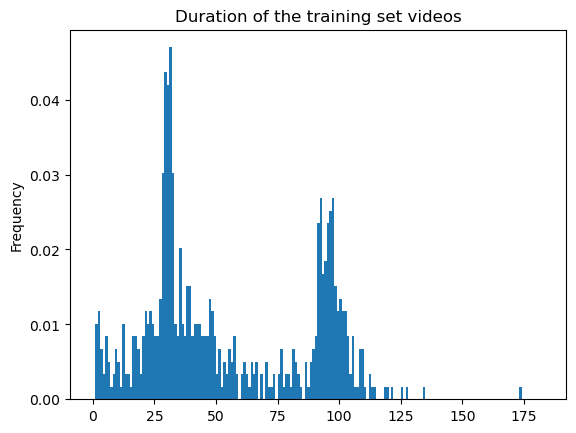

In [20]:
durations = df_ann['stop_s'] - df_ann['start_s']
max_duration = durations.max()
bin_width = 1 #seconds
bins = list(range(0, int(max_duration) + 1, int(bin_width)))
durations.sort_values().plot(kind='hist', bins=bins, density=True, title='Duration of the training set videos')

# Considerazioni
Gli split 1, 2 e 3 sono la stessa cosa, ma cambiano nel tipo 'training-validation' per fare un 3-fold.

# Feature extraction - IMU

In [175]:
imu_file = 'sbj_10.csv'
sample_rate = 50 #Hz, source
downsampling_rate = 25 #Hz, target
wsize = 5 #seconds
woverlap = 2.5 #seconds


In [176]:
sensors = pd.read_csv(os.path.join(inertial_dir, imu_file))
sensors = sensors.drop(columns=['label'])
sensors

,sbj_id,right_arm_acc_x,right_arm_acc_y,right_arm_acc_z,right_leg_acc_x,right_leg_acc_y,right_leg_acc_z,left_leg_acc_x,left_leg_acc_y,left_leg_acc_z,left_arm_acc_x,left_arm_acc_y,left_arm_acc_z
0,10,0.981982,0.371020,0.025510,0.988918,0.065501,0.148098,0.982915,-0.083130,0.021120,-0.950163,0.274206,0.111081
1,10,0.983750,0.345706,-0.010884,0.990056,0.064240,0.149030,0.987285,-0.079543,0.018310,-0.955690,0.279296,0.099610
2,10,0.971634,0.340019,-0.030786,0.989048,0.064956,0.147591,0.992469,-0.082871,0.015696,-0.961587,0.284993,0.094157
3,10,0.958144,0.354297,-0.030645,0.988378,0.068118,0.146044,0.993909,-0.085662,0.013044,-0.965589,0.289072,0.089787
4,10,0.957273,0.373711,-0.021169,0.990330,0.070336,0.146870,0.990640,-0.088543,0.017493,-0.966240,0.291954,0.085833
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199245,10,0.893520,-0.358096,-0.841556,0.443600,-0.568360,1.082030,0.932721,-0.029403,0.479873,-0.994943,0.025287,-0.149729
199246,10,0.890451,-0.281284,-0.788299,0.352229,-0.708798,0.813478,0.880057,-0.023242,0.485883,-1.018028,0.119410,-0.202391
199247,10,0.941280,-0.182932,-0.720960,0.252565,-0.903455,0.553040,0.833505,0.025358,0.484819,-1.054722,0.070287,-0.196611
199248,10,1.004967,-0.166500,-0.824787,0.192560,-0.903387,0.544455,0.906807,0.048203,0.411519,-1.099370,0.011230,-0.173830


In [177]:
sensors.isna().any()

sbj_id             False
right_arm_acc_x    False
right_arm_acc_y    False
right_arm_acc_z    False
right_leg_acc_x    False
right_leg_acc_y    False
right_leg_acc_z    False
left_leg_acc_x     False
left_leg_acc_y     False
left_leg_acc_z     False
left_arm_acc_x      True
left_arm_acc_y      True
left_arm_acc_z      True
dtype: bool

In [35]:
right_arm_acc = sensors[['right_arm_acc_x', 'right_arm_acc_y', 'right_arm_acc_z']]
right_arm_acc = torch.tensor(right_arm_acc.values.T, dtype=torch.float32)
right_arm_acc.shape

torch.Size([3, 125175])

In [36]:
import librosa

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_frames = waveform.shape[0]
    time_axis = torch.arange(0, num_frames) / sr

    ax.plot(time_axis, waveform, linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

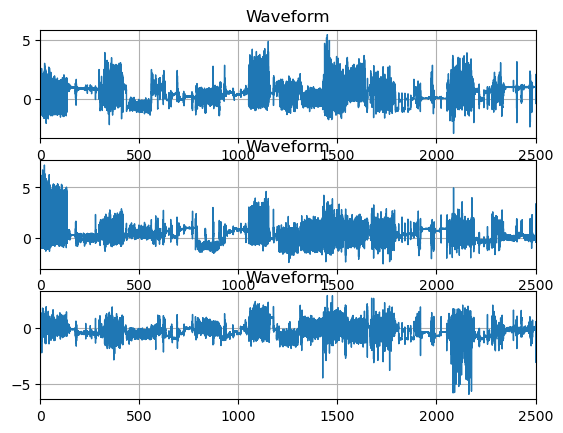

In [37]:
fig, axs = plt.subplots(3,1)
plot_waveform(right_arm_acc[0, :], sample_rate, ax=axs[0])
plot_waveform(right_arm_acc[1, :], sample_rate, ax=axs[1])
plot_waveform(right_arm_acc[2, :], sample_rate, ax=axs[2])
plt.show()

In [38]:
accl_fft = torch.fft.fft(
    right_arm_acc,
    dim=1,
)

In [39]:
def plot_fft(accl_fft):
    # Plotting the real part of accl_fft
    plt.plot(accl_fft.real)
    plt.xlabel('f (Hz)')
    plt.ylabel('|fft(X)|')
    plt.title('Real part of accl_fft')
    plt.show()


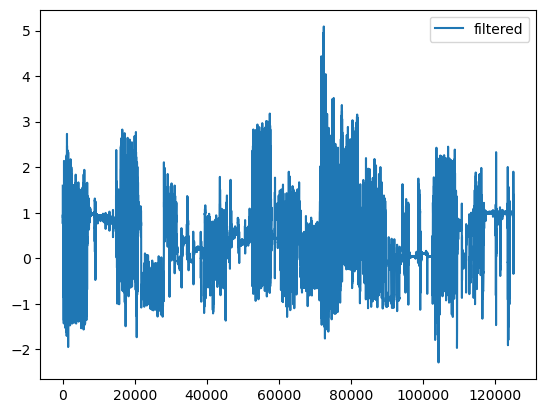

In [40]:
fs = sample_rate
fc = 5  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
b, a = sp.signal.butter(5, w, 'low')
output = sp.signal.filtfilt(b, a, right_arm_acc[0].numpy())
plt.plot(output, label='filtered')
plt.legend()
plt.show()

In [41]:
right_arm_acc_x_filtered = torch.from_numpy(np.float32(output).copy())
right_arm_acc_x_filtered.shape

torch.Size([125175])

In [42]:
right_arm_acc_x_filtered.dtype

torch.float32

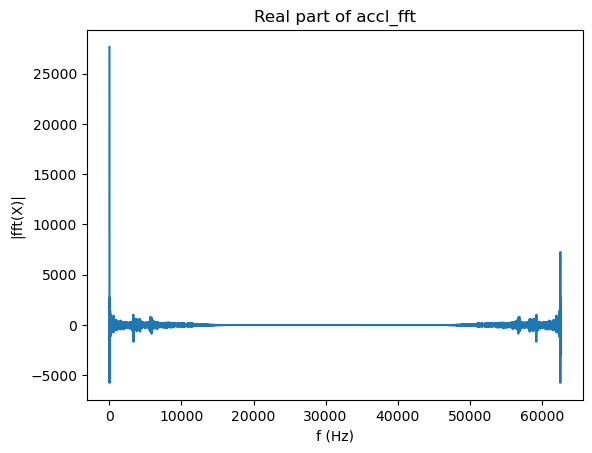

In [44]:
resampled = T.Resample(sample_rate, downsampling_rate)(right_arm_acc_x_filtered)
accl_fft = torch.fft.fft(
    resampled
)
plot_fft(accl_fft)

# Spectrogram

In [45]:
def normalize_tensor(tensor):
    tensor = torch.from_numpy(tensor)
    min_value = torch.min(tensor)
    max_value = torch.max(tensor)
    normalized_tensor = (tensor - min_value) / (max_value - min_value)
    return normalized_tensor

def cut_and_pad(signal, sampling_rate, seconds):
    padded_signal = torch.zeros(sampling_rate * seconds)
    if signal.shape[0] < sampling_rate * seconds:
        padded_signal = torch.zeros(sampling_rate * seconds)
        padded_signal[:signal.shape[0]] = signal
    else:
        padded_signal = signal[:sampling_rate * seconds]

    return padded_signal

In [74]:
focus = 0
sec = 5 #FIXME: con 2 e 5 secondi non funziona
downsampling_rate = 25
prova_2s = right_arm_acc[:, focus:focus + int(sample_rate * sec)]
prova_2s = torchaudio.functional.resample(prova_2s, sample_rate, sample_rate)
# prova_2s = accl_x_interp_torch
# prova_2s = normalize_tensor(prova_2s.numpy())
# 

n_ffts = [32, 64, 128, 256]
hop_length = [2, 4, 8, 16]

specs = []
for i, n_fft in enumerate(n_ffts):
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        hop_length=2,
        center=True,
        pad_mode="reflect",
        power=2.0,
        normalized=True,
    )
    spectrogram.double()

    # 1. spettrogramma
    # 2. da amplitude a dB
    # 3. normalizzare [0,1]
    prova = spectrogram(prova_2s)
    prova = librosa.power_to_db(prova)
    # prova = normalize_tensor(prova)
    specs.append(prova)

In [75]:
for i in range(len(specs)):
    print(specs[i].shape) 

(3, 17, 126)
(3, 33, 126)
(3, 65, 126)
(3, 129, 126)


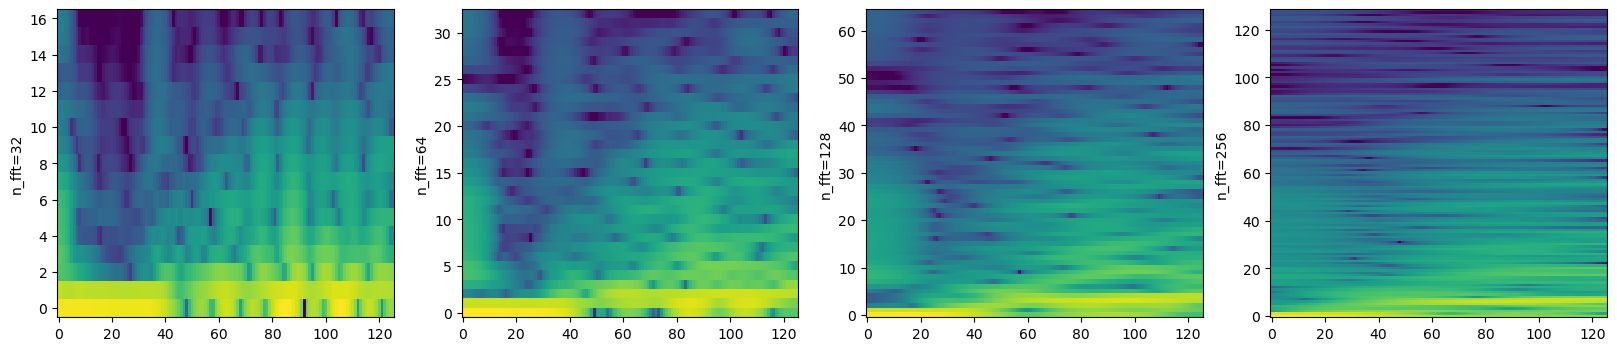

In [76]:
fig, axs = plt.subplots(1, len(specs), figsize=(20,4))
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"{n_fft=}", ax=axs[i])
    axs[i].set_xlabel(None)

In [51]:
resized_spec = torchvision.transforms.Resize((64, 64))(torch.tensor(specs[2]))

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
plot_spectrogram(resized_spec[0], ylabel=f"{n_ffts[2]=}", ax=axs)

# Mel Spectrogram

In [71]:
n_ffts = [32, 64, 128, 256]
hop_length = [2, 4, 8, 16]
downsampling_rate = sample_rate
specs_mel = []
for i, n_fft in enumerate(n_ffts):
    mel_spectrogram = T.MelSpectrogram(
        n_mels=25,
        sample_rate=downsampling_rate,
        n_fft=n_fft,
        hop_length=4,
        center=True,
        pad_mode="reflect",
        power=2.0,
        normalized=True,
    )
    mel_spectrogram.double()

    # 1. spettrogramma
    # 2. da amplitude a dB
    # 3. normalizzare [0,1]
    prova = mel_spectrogram(prova_2s)
    prova = librosa.power_to_db(prova)
    prova = normalize_tensor(prova)
    specs_mel.append(prova)

In [72]:
for spec in specs_mel:
    print(spec.shape)

torch.Size([3, 25, 63])
torch.Size([3, 25, 63])
torch.Size([3, 25, 63])
torch.Size([3, 25, 63])


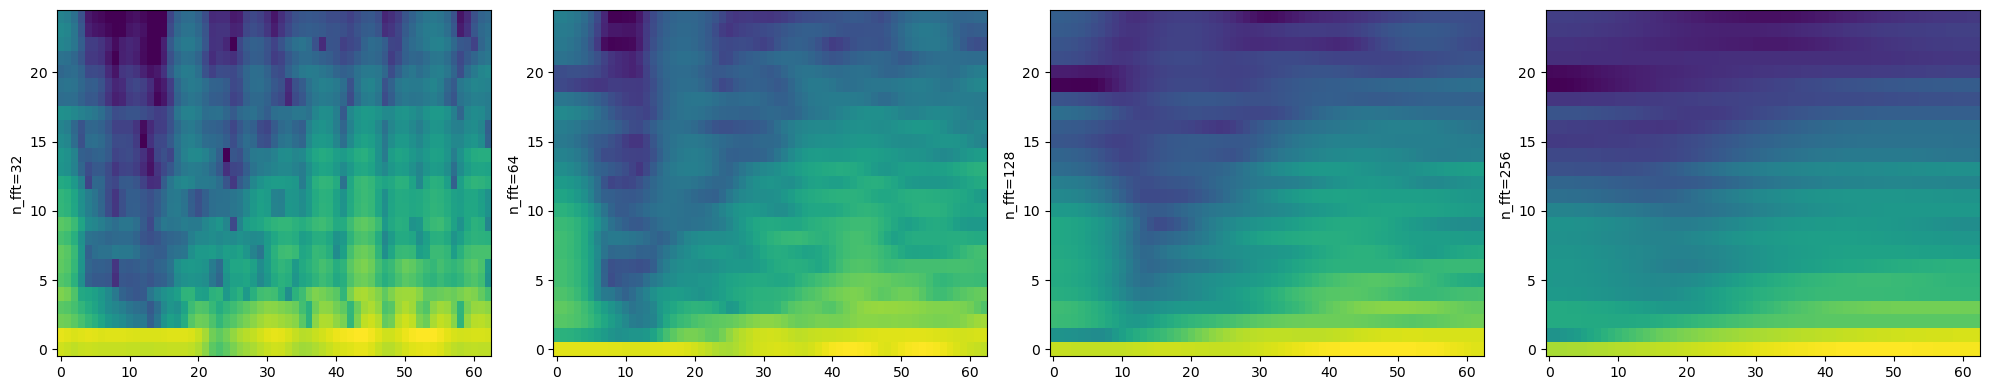

In [73]:
fig, axs = plt.subplots(1, len(specs_mel), figsize=(20,4))
for i, (spec, n_fft) in enumerate(zip(specs_mel, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"{n_fft=}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

# SSL split

Create annotations for SSL split

- window = 10 s
- overlap = 50%

In [100]:
annotations_ssl_wear = 'annotations_ssl_wear.pkl'

df_ssl_wear = pd.DataFrame(columns=[
    'subject',
    'start_s',
    'stop_s'
])

In [98]:
aux = {}

for i, row in df_ann1.iterrows():
    
    if  i.startswith('sbj') and (i not in aux) and (row['database']['subset'] == 'Training'):
        print(i, row['database']['subset'])
        aux[i] = {
            'duration_s': row['database']['duration']
        }


sbj_6 Training
sbj_7 Training
sbj_8 Training
sbj_9 Training
sbj_10 Training
sbj_11 Training
sbj_12 Training
sbj_13 Training
sbj_14 Training
sbj_15 Training
sbj_16 Training
sbj_17 Training


In [41]:
aux

{'sbj_6': {'duration_s': 2503.5},
 'sbj_7': {'duration_s': 2853.0},
 'sbj_8': {'duration_s': 2495.0},
 'sbj_9': {'duration_s': 2166.0},
 'sbj_10': {'duration_s': 3985.0},
 'sbj_11': {'duration_s': 2222.0},
 'sbj_12': {'duration_s': 3270.0},
 'sbj_13': {'duration_s': 3978.0},
 'sbj_14': {'duration_s': 3201.0},
 'sbj_15': {'duration_s': 2603.0},
 'sbj_16': {'duration_s': 3510.0},
 'sbj_17': {'duration_s': 3091.0}}

In [101]:
overlap_in_s = 5
window_size = 10
sampling_rate_accl = 50

for i, row in aux.items():
    duration = row['duration_s']
    n_windows = int((duration * (window_size / overlap_in_s)) / window_size)

    print(f'{i=}, {n_windows=}')

    for j in range(n_windows):
        start = j * overlap_in_s
        stop = start + window_size

        df_ssl_wear.loc[len(df_ssl_wear.index)] = [i, start, stop]
df_ssl_wear

i='sbj_6', n_windows=500
i='sbj_7', n_windows=570
i='sbj_8', n_windows=499
i='sbj_9', n_windows=433
i='sbj_10', n_windows=797
i='sbj_11', n_windows=444
i='sbj_12', n_windows=654
i='sbj_13', n_windows=795
i='sbj_14', n_windows=640
i='sbj_15', n_windows=520
i='sbj_16', n_windows=702
i='sbj_17', n_windows=618


,subject,start_s,stop_s
0,sbj_6,0,10
1,sbj_6,5,15
2,sbj_6,10,20
3,sbj_6,15,25
4,sbj_6,20,30
...,...,...,...
7167,sbj_17,3065,3075
7168,sbj_17,3070,3080
7169,sbj_17,3075,3085
7170,sbj_17,3080,3090


In [92]:
len(df_ssl_wear.query('subject == "sbj_6"'))

12506